In [1]:
import numpy as np
from matplotlib import pyplot as plt
import networkx as nx
import scipy
from sklearn.covariance import OAS
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid

np.random.seed(0)

# Useful functions

### Generate random graphs

In [2]:
def is_connected(G):
    return nx.is_connected(G)
    
def draw_graph(G):
    plt.figure(figsize=(20, 10))
    nx.draw(G)
    plt.show()
    
def generate_graph(name, order=100):
    """Return the adjacency matrix of a random graph.
    
    Parameters:
        name  --  'cycle', 'complete', 'erdo', 'stochastic_block_model' or 'random_geometric'.
        order  --  number of vertices in the graph.
    """
    if name == 'cycle':
        G = nx.cycle_graph(order)
    elif name == 'complete':
        G = nx.complete_graph(order)
    elif name == 'erdo':
        p = 4 * np.log(order) / order
        G =  nx.erdos_renyi_graph(order, p, seed=0)
        print(f"Number of edges: {nx.number_of_edges(G)}, Expected number: {np.round(order * (order - 1) / 2* p, 3)}, Probability of an edge: {np.round(p, 3)}")
    elif name == 'stochastic_block_model':
        nb_cluster = 2
        sub_order = 50
        p1 = 0.35
        p2 = 0.02172959999  
        sizes = [sub_order] * nb_cluster
        probs = []
        for c in range(nb_cluster):
            probs.append([p2] * nb_cluster)
            probs[-1][c] = p1
        G = nx.stochastic_block_model(sizes, probs, seed=1)
        print(f"Number of edges: {nx.number_of_edges(G)}, Expected number: {np.round(nb_cluster * sub_order * (sub_order - 1) / 2 * p1 + (nb_cluster * sub_order * (nb_cluster * sub_order - 1) / 2 - nb_cluster * sub_order * (sub_order - 1) / 2) * p2, 3)}, Probability of an edge inside a community: {np.round(p1, 3)}, Probability of an edge outside: {np.round(p2, 3)}, Number of communities: {nb_cluster}")
    elif name == 'random_geometric':
        r = 0.274332 # 185976
        G = nx.random_geometric_graph(order, r, seed=0)
        print(f"Number of edges: {nx.number_of_edges(G)}, Expected number: {np.round((order - 1) * order / 2 * (r**4/2-8/3*r**3+np.pi*r**2), 3)}, Probability of an edge: {np.round(r**4/2-8/3*r**3+np.pi*r**2, 3)}")
    A = nx.adjacency_matrix(G)
    A = scipy.sparse.csr_matrix.toarray(A)
    return G, A

### Classify data

In [3]:
# Using classifiers from scikit-learn
def classifier(name):
    if name == 'LDA':
        oa = OAS(store_precision=False, assume_centered=False)
        clf = LinearDiscriminantAnalysis(solver='lsqr', covariance_estimator=oa)
    elif name == 'NCM':
        clf = NearestCentroid()
    elif name == 'LR':
        clf = LogisticRegression(random_state=0, max_iter=500)
    return clf

### Generate data samples

In [4]:
def generate_two_class_indicator_vectors(length):
    """Return a list containing two opposite signals, each one representating a class.
    
    Parameters:
        length  --  length of the signals.
    """
    signals = [np.random.uniform(low=-1, high=1, size=length)]
    signals.append(-signals[0])
    return signals


def add_noise(X, scale):
    X = X + scale * np.random.normal(0, 1, (X.shape[0], X.shape[1]))
    return X


def diffusion_on_graph(X, GSO):
    return np.matmul(X, GSO)


def simulate_data(n_shot, n_query, class_signals, GSO, alpha=1, beta=1):
    """Return a data matrix of shape [n_class*(n_shot+n_query), length] and a vector label of shape [n_class*(n_shot+n_query)].
    In the data matrix, the first n_shot samples are the samples associated to the first class. The next n_shot samples are associated 
    to the second class, and so on. Then, the next n_query samples are associated to the first class. The next n_query samples are 
    associated to the second class and so on. Each sample is generated by adding two noises ato its class signal: a gaussian white 
    noise diffused on a graph structure scaled by alpha and a gaussian white noise scaled by beta.
    
    Parameters:
        n_shot  -- number of training examples per class.
        n_query  -- number of test examples per class.
        class_signals  -- list containing n_class signals representative of n_class classes.
        GSO  --  graph shift operator over which the white noise is diffused.
        alpha -- coefficient by which the white Gaussian noise diffused on the GSO is multiplied.
        beta -- coefficient by which the white Gaussian noise is multiplied.
    """
    n_class = len(class_signals)
    length = class_signals[0].shape[0]
    
    # Initialize the data samples and their labels.
    data = np.zeros((n_class * (n_shot + n_query), length))
    labels = np.zeros(n_class * (n_shot + n_query))
    
    # Add gaussian white noise and diffuse it.
    data = add_noise(data, alpha)
    data = diffusion_on_graph(data, GSO)
    
    # Add gaussian white noise.
    data = add_noise(data, beta)
    
    # Add the class signals.
    for c in range(n_class):
        for i in range(n_shot):
            data[c * n_shot + i] += class_signals[c]
            labels[c * n_shot + i] = c          
    for c in range(n_class):
        for i in range(n_query):
            data[n_class * n_shot + c * n_query + i] += class_signals[c]
            labels[n_class * n_shot + c * n_query + i] = c

    return data, labels

### Preprocessing methods

In [5]:
# Our method.
def graph_fourier_transform(GSO):
    """Return the eigenvectors and eigenvalues of the graph shift operator GSO (e.g. adjacency matrix).
    """
    # Check whether the GSO is symmetric.
    assert (GSO == GSO.T).all()
    # Compute eigenvalues w and eigenvectors v.
    # The eigenvalues in w are sorted in ascending order.
    # v[:, i] is the normalized eigenvector corresponding to the eigenvalue w[i].
    w, v = np.linalg.eigh(GSO)
    return w, v


def sorting_egv(w, v):
    """Return the eigenvalues w / eigenvectors v sorted according to the ascending squared eigenvalues.
    """
    indexes = np.argsort(w ** 2)
    v = v[:, indexes]
    w = w[indexes]
    return w, v

    
def project_data(data, basis):
    """Return data projected into the vectors of basis.
    
    Parameters:
        data  --  matrix of shape [number of samples, length].
        basis  --  matrix of shape [length, number of vectors].
    """
    return np.matmul(data, basis)


def optimal_weights(w, sigma):
    weights = []
    for i in range(w.shape[0]):
        weights.append(1 / np.sqrt(w[i]**2 + sigma ** 2))
    return np.array(weights)


def optimize(data, w, sigma):
    weights = optimal_weights(w, sigma)
    return data * weights


def denoise(data, w, v, sigma):
    # Projection in the spectral space.
    proj_data = project_data(data, v)
    # Denoising.
    denoised_data = optimize(proj_data, w, sigma)
    return denoised_data

In [6]:
# Other preprocessing methods.
def preprocess(data, test, fct, v=None):
    """Return data projected into the vectors of basis.
    
    Parameters:
        data  --  matrix of shape [number of samples, length].
        test  --  matrix of shape [number of test samples, length].
        fct   --  'norm', 'std' or 'sp_std'. Function used to preprocess the samples. 
    """
    if fct == 'sp_std':
        # print("Projection")
        proj_data = project_data(data, v)
        proj_test = project_data(test, v)
        # print("Each feature is divided by its standard deviation computed on the training data.")
        std_data = np.std(proj_data, axis=0, keepdims=True)
        data_prep = proj_data / std_data
        test_prep = proj_test / std_data
    elif fct == 'norm':
        # print("Each data sample is divided by its norm.")
        norm_data = np.linalg.norm(data, axis=1, keepdims=True)
        data_prep = data / norm_data
        norm_test = np.linalg.norm(test, axis=1, keepdims=True)
        test_prep = test / norm_test
    elif fct == 'std':
        # print("Each feature is divided by its standard deviation computed on the training data.")
        std_data = np.std(data, axis=0, keepdims=True)
        data_prep = data / std_data
        test_prep = test / std_data
    return data_prep, test_prep

### Statistics

In [7]:
def compute_confidence_interval(data):
    """
    Compute 95% confidence interval.
    
    Parameters:
        data -- Array containing an estimation of a value obtained across different data samples.
    """
    a = 1.0 * np.array(data)
    m = np.mean(a)
    std = np.std(a)
    pm = 1.96 * (std / np.sqrt(len(a)))
    return m, pm

# Experiment

In [8]:
# Parameters
graph_name = 'random_geometric'  # graph name: 'erdo', 'stochastic_block_model' or 'random_geometric'.
order = 100  # number of vertices in the graph.
n_class = 2  # number of classes.
n_shot = 5  # number of training examples per class.
n_query = 1000  # number of test examples per class.
alpha = 1  # coefficient by which the white Gaussian noise diffused on the GSO is multiplied.
beta = 1  # coefficient by which the white Gaussian noise is multiplied.

In [9]:
# Retrieve the graph
G, GSO = generate_graph(graph_name, order)
assert is_connected(G)

Number of edges: 919, Expected number: 911.824, Probability of an edge: 0.184


In [10]:
# Generate the class signals
class_signals = generate_two_class_indicator_vectors(order)

In [11]:
# Prepare the results
list_of_clf = ['NCM', 'LR', 'LDA']
list_of_fct = ['sp_std', 'std', 'norm']

acc = {}
our_acc = {}
prep_acc = {}
for fct in list_of_fct:
    prep_acc[fct] = {}

for name in list_of_clf:
    acc[name] = []
    our_acc[name] = []
    for fct in list_of_fct:
        prep_acc[fct][name] = []

In [12]:
for exp in range(100):
    # Generate the class signals
    class_signals = generate_two_class_indicator_vectors(order)

    # Generate the data samples
    data, labels = simulate_data(n_shot, n_query, class_signals, GSO, alpha, beta)
    
    X_train = data[:n_class * n_shot]
    X_test = data[n_class * n_shot:]
    y_train = labels[:n_class * n_shot]
    y_test = labels[n_class * n_shot:]
    
    # Graph Fourier Transform.
    w, v = graph_fourier_transform(GSO)
    w, v = sorting_egv(w, v)
    
    # Whitening in the spectral space.
    sigma = beta / alpha
    X_train_denoised = denoise(X_train, w, v, sigma)
    X_test_denoised = denoise(X_test, w, v, sigma)
    
    # Other preprocessing.
    X_train_prep = {}
    X_test_prep = {}
    for fct in list_of_fct:
        X_train_prep[fct], X_test_prep[fct] = preprocess(X_train, X_test, fct, v)
    
    for name in list_of_clf:
        # Retrieve the classifier.
        clf = classifier(name)
        # Classification score without preprocessing.
        clf.fit(X_train, y_train)
        acc[name].append(clf.score(X_test, y_test))
        # Classification score after denoising.
        clf.fit(X_train_denoised, y_train)
        our_acc[name].append(clf.score(X_test_denoised, y_test))
        # Classification score after preprocessing.
        for fct in list_of_fct:
            clf.fit(X_train_prep[fct], y_train)
            prep_acc[fct][name].append(clf.score(X_test_prep[fct], y_test))
            

In [13]:
means = np.zeros((len(list_of_clf), 2 + len(list_of_fct)))
confs = np.zeros((len(list_of_clf), 2 + len(list_of_fct)))
for i, name in enumerate(list_of_clf):
    mean, conf = compute_confidence_interval(np.array(acc[name]))
    mean = np.round(mean * 100, 2)
    conf = np.round(conf * 100, 2)
    print(f'{name}: {mean} +- {conf}')
    means[i, 0] = mean
    confs[i, 0] = conf
    
    mean, conf = compute_confidence_interval(np.array(our_acc[name]))
    mean = np.round(mean * 100, 2)
    conf = np.round(conf * 100, 2)
    print(f'Denoising: {mean} +- {conf}')
    means[i, 1] = mean
    confs[i, 1] = conf
    
    for j, fct in enumerate(list_of_fct):
        mean, conf = compute_confidence_interval(np.array(prep_acc[fct][name]))
        mean = np.round(mean * 100, 2)
        conf = np.round(conf * 100, 2)
        print(f'Preprocessing {fct}: {mean} +- {conf}')
        means[i, j+2] = mean
        confs[i, j+2] = conf
    print(' ')

NCM: 57.41 +- 0.77
Denoising: 99.38 +- 0.1
Preprocessing sp_std: 97.98 +- 0.29
Preprocessing std: 58.15 +- 0.77
Preprocessing norm: 58.53 +- 0.78
 
LR: 64.53 +- 1.08
Denoising: 99.3 +- 0.12
Preprocessing sp_std: 97.84 +- 0.3
Preprocessing std: 63.33 +- 0.98
Preprocessing norm: 59.85 +- 0.84
 
LDA: 64.55 +- 1.03
Denoising: 99.28 +- 0.12
Preprocessing sp_std: 97.83 +- 0.3
Preprocessing std: 63.7 +- 0.97
Preprocessing norm: 64.03 +- 1.05
 


# Visualize a graph

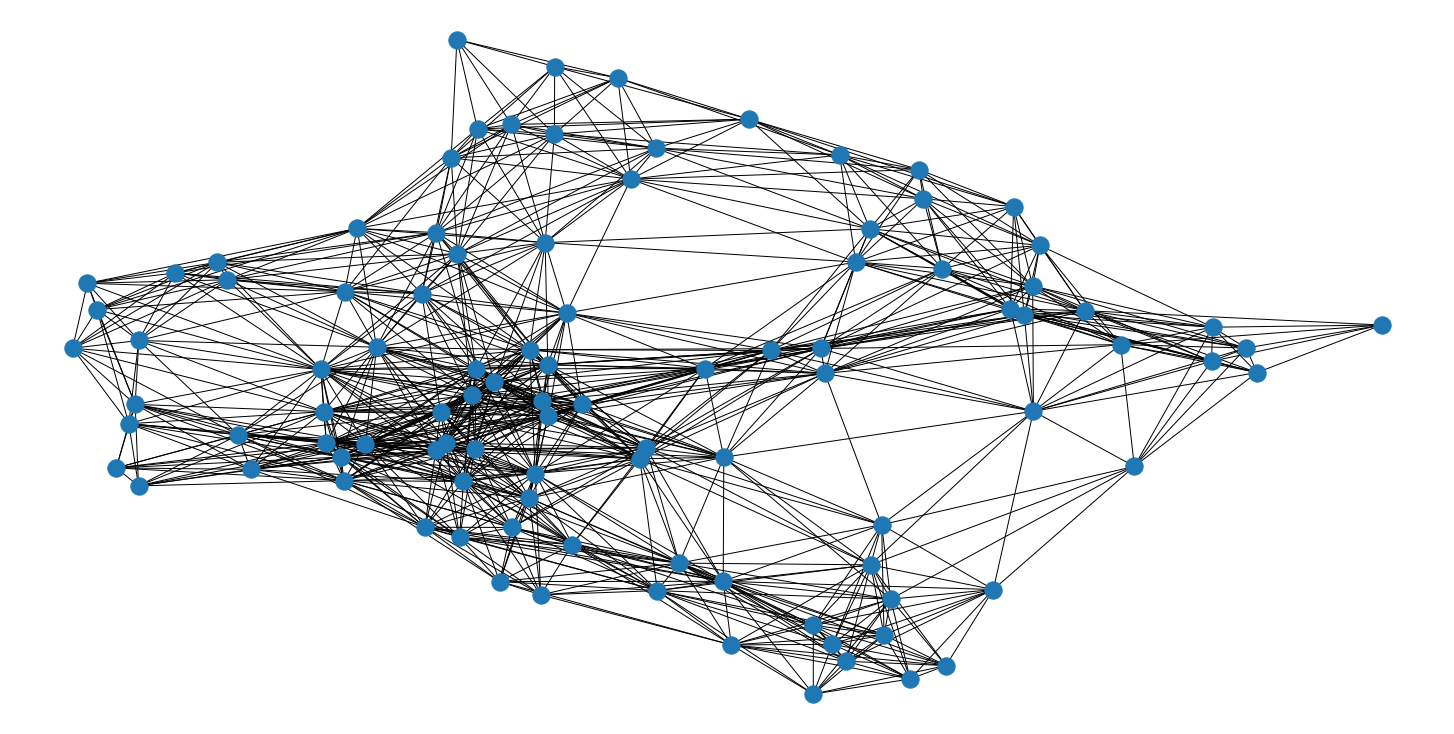

In [14]:
draw_graph(G)